## Hodgkin Huxley Model

As with the leaky integrate and fire model, the Hodgkin-Huxley model of a neuron is realized by considering a current balance law, treating the neural membrane as an electric circuit. Some models consider the fact that the neuron is spatially extended, which requires some knowledge of advanced linear algebra and/or partial differential equations (see most of Ch.3 of Gerstner et al (2014)). We simply consider a local model here treating the neuron as a single piece of membrane, so the applied current $I(t)$ is split into capacitive current $I_C(t)$ and the sum of all ion channel currents $I_k(t)$ ($k=1,2,....$), so
$$
I(t) = I_c(t) + \sum_k I_k(t).
$$
The Hodgkin-Huxley model has three ion channels as shown here:
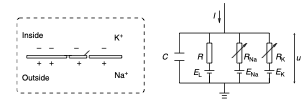
a sodium channel (Na), potassium channel (K), and leak channel (L) sometime considered a chloride channel. Noting the capacitance formula $I_C = C du/dt$, we have
$$
C \frac{du}{dt} = - I_{Na}(t) - I_K(t) - I_L(t) + I(t)
$$
It is important to note that each of these ion channel terms is really the average of many ion channels. As in the LIF model, the leak channel's current is proportional to the difference between the neuron voltage $u$ and the resting potential $E_L$ so Ohm's law ($V=IR$) implies $u-E_L = I_L R$ or $I_L = g_L (u-E_L)$ where $g_L = 1/R$ is the *conductance* of the channel.

The other two channels follow the same physical laws, but have a probability of being open between zero and one that depends on the voltage $u$, and this probability evolves according to dynamic *gating variables* $m$, $n$, and $h$. The sodium channels is controlled by $m$ and $h$, so $1/R_{Na} = g_{Na} m^3 h$, so $m$ describes the channels opening and $h$ controls channel inactivation (blocking). The potassium channel conductance is $1/R_K = g_K n^4$, so the sum of current is
$$
\sum_{k} I_k = g_{Na} m^3 h(u - E_{Na}) + g_K n^4 (u - E_K) + g_L (u - E_L),
$$
where the variable prefactors ($m,h,n$) determine the fraction of ion channels that are open. The gating variables evolve according to *voltage-gated* transition rates, meaning the rate of transition between open $\alpha_x$ and closed $\beta_x$ changes with the voltage. Putting these equations together with the voltage differential equation yields the system
$$
C \frac{du}{dt} = I(t) - g_{Na} m^3 h(u - E_{Na}) - g_K n^4 (u - E_K) - g_L (u - E_L)  \\
\frac{dm}{dt} = \alpha_m (u) (1-m) - \beta_m (u) m  \\
\frac{dn}{dt} = \alpha_n (u) (1-n) - \beta_n (u) n  \\
\frac{dh}{dt} = \alpha_h(u) (1-h) - \beta_h (u) h.
$$
This fully models the voltage dynamics of a neuron up to the needed parameters. We build code using classic parameters (rather than those in Gerstner et al (2014)) from Hodgkin-Huxley shifted so that the resting potential of the neuron is close to zero. First, we present the resting potential $E_x$ and conductance $g_x$ parameters:
$E_{Na} = 115$mV, $E_{K} = -12$mV, $E_L = 10.6$mV 
$g_{Na} = 120$mS/cm$^2$, $g_K = 36$mS/cm$^2$, $g_L = 0.3$mS/cm$^2$,
where the conductance is given in millisiemens per area (square centimeters). Membrane conductance is assumed to be $C = 1\mu$F/cm$^2$. Note, in the code we will take ratios of conductance and capacitance, which will yield mS/$\mu$F$=$1/ms (1/units of time). The form of the voltage-depedent gating variable switching rates is somewhat complicated and will be given in the python code below.

Now, to walk through the Hodgkin-Huxley simulation code, we start by importing plotting and numerical computation tools along with the ode integration package.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.integrate import odeint

Subsequently, we define the conductance, voltage reversal potential, and capacitance:

In [2]:
gK = 36.0   # average potassium channel conductance per unit area (mS/cm^2)
gNa = 120.0 # average sodium channel conductance per unit area (mS/cm^2)
gL = 0.3    # average leak channel conductance per unit area (mS/cm^2)

EK = -12.0  # potassium potential (mV)
ENa = 115.0 # Sodium potential (mV)
EL = 10.6   # leak potential (mV)

Cm = 1.0    # membrane capacitance per unit area (uF/cm^2)

Then the strength of the constant external current:

In [3]:
Id = 10    # membrane capacitance per unit area (uF/cm^2)

Then the end time and time vector

In [4]:
T = 100.0    # end time (in milliseconds)
tvec = np.linspace(0, T, 10000)    # time vector

Next, the voltage-gated ion channel rate functions. Note, the *def* syntax gives functions which must return something:

In [5]:
# potassium ion-channel rate functions
def alpha_n(Vm):
    return (0.1-0.01*Vm)/(np.exp(1-0.1*Vm)-1)

def beta_n(Vm):
    return 0.125*np.exp(-Vm/80)

# sodium ion-channel rate functions
def alpha_m(Vm):
    return (2.5-0.1*Vm)/(np.exp(2.5-0.1*Vm)-1)

def beta_m(Vm):
    return 4*np.exp(-Vm/18)

# chloride ion-channel rate functions
def alpha_h(Vm):
    return 0.07*np.exp(-Vm/20)

def beta_h(Vm):
    return 1/(np.exp(3-0.1*Vm)+1)

What motivates the above forms of the voltage-dependent rates? Consider for instance both $\beta_n$ and $\beta_m$, which are both exponentially decaying in the voltage ($V_m$ in the code). This means that when the voltage is low (when the neuron is quiet) the rate of off transitions is higher, which keeps the neuron from spiking spontaneously. Thus, an external current is needed to move the neuron from equilibrium.

We also compute the steady state values of the gating variables by solving for the equilibria of the gating variable equations when $V_m = 0$mV (about its resting potential).

In [6]:
# n, m, and h steady-state values
def n_inf(Vm=0.0):
    return alpha_n(Vm) / (alpha_n(Vm) + beta_n(Vm))

def m_inf(Vm=0.0):
    return alpha_m(Vm) / (alpha_m(Vm) + beta_m(Vm))

def h_inf(Vm=0.0):
    return alpha_h(Vm) / (alpha_h(Vm) + beta_h(Vm))

These will be useful in setting initial conditions. Lastly, we define the right hand sides of the differential equations as above, again as a function.

In [7]:
# compute derivatives
def compute_derivatives(y, t0):
    dy = np.zeros((4,))
    
    Vm = y[0]
    n = y[1]
    m = y[2]
    h = y[3]
    
    # dVm/dt
    GK = (gK/Cm)*np.power(n,4.0)
    GNa = (gNa/Cm)*np.power(m,3.0)*h
    GL = gL/Cm
    
    dy[0] = (Id/Cm)-(GK*(Vm-EK))-(GNa*(Vm-ENa))-(GL*(Vm-EL))
    
    # dn/dt
    dy[1] = (alpha_n(Vm)*(1-n))-(beta_n(Vm)*n)
    
    # dm/dt
    dy[2] = (alpha_m(Vm)*(1-m))-(beta_m(Vm)*m)
    
    # dh/dt
    dy[3] = (alpha_h(Vm)*(1-h))-(beta_h(Vm)*h)
    
    return dy

Now we are ready to set initial conditions as an array:

In [8]:
# state (Vm, n, m, h)
Y = np.array([0.0, n_inf(), m_inf(), h_inf()])

And solve the ODE system using *odeint*

In [9]:
# solve ODE system
# vy = (Vm[t0:tmax], n[t0:tmax], m[t0:tmax], h[t0:tmax])
Vy = odeint(compute_derivatives, Y, tvec)

And finally plot the neuron potential as a function of time.

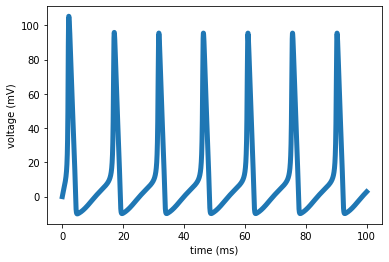

In [10]:
# plot neuron potential
fig = plt.figure()       
plt.plot(tvec, Vy[:, 0],linewidth=5)
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')
plt.show()

Note, you can go back up and change parameters and rerun all the scripts to see how this changes the evolution of voltage in the model. You will use the accompanying python code hh_spike.py as part of HW1 to study the HH model.